Перед вами данные взаимодействий с рекламными объявлениями на некоторой площадке за 6 дней. И таблица с характеристиками рекламных клиентов (тех, кто разместил эти объявления).

`ads_data.csv `– данные взаимодействий с рекламными объявлениями  
`ads_clients_data.csv` – характеристики рекламных клиентов

In [129]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px

In [130]:
# настройки отображения графика
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

- time – время
- date – дата
- event – действие (просмотр/клик)
- platform – платформа
- ad_id – id объявления
- client_union_id – id рекламного кабинета
- campaign_union_id – id рекламной кампании
- ad_cost_type – тип оплаты
- ad_cost – цена
- has_video – есть ли видео
- target_audience_count – размер аудитории


In [131]:
ads_data = pd.read_csv('ads_data.csv')
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


- date – дата
- client_union_id – id рекламного кабинета
- community_id – id сообщества
- create_date – дата создания рекламного клиента

In [133]:
ads_clients_data = pd.read_csv('ads_clients_data.csv')
ads_clients_data.head()

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08


In [134]:
ads_clients_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122078 entries, 0 to 122077
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   date             122078 non-null  object
 1   client_union_id  122078 non-null  int64 
 2   community_id     122078 non-null  int64 
 3   create_date      122078 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.7+ MB


Для начала посчитаем среднее количество разных рекламных событий (показы и клики) по объявлениям.

In [136]:
ads_data.groupby(['ad_id', 'event'], as_index=False) \
    .agg({'time' : 'count'}) \
    .pivot(columns='event', values=['time'], index='ad_id') \
    .fillna(0) \
    .mean().round(2)

      event
time  click    113.14
      view     923.13
dtype: float64

In [137]:
click_and_view = ads_data.groupby(['ad_id', 'event'], as_index=False) \
    .agg({'time' : 'count'}) \
    .pivot(columns='event', values=['time'], index='ad_id') \
    .fillna(0)

In [138]:
click_and_view.columns = ['click', 'view']

In [139]:
click_and_view = click_and_view.reset_index()
click_and_view

,ad_id,click,view
0,2,1.0,101.0
1,3,3.0,184.0
2,1902,1.0,41.0
3,2064,0.0,35.0
4,2132,1.0,58.0
...,...,...,...
960,122004,4.0,100.0
961,122013,0.0,156.0
962,122023,0.0,68.0
963,122031,1.0,138.0


Давайте посмотрим на распределение показов объявлений!

По оси x – число показов  
По оси y – доля объявлений с такими показами  
Прологарифмируйте число показов, а затем постройте график распределения

In [140]:
click_and_view = click_and_view.query("view != 0")
click_and_view['log_view'] = np.log(click_and_view.view)
click_and_view.head(5)

C:\Users\Администратор\AppData\Local\Temp\ipykernel_13680\2684707376.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ad_id,click,view,log_view
0,2,1.0,101.0,4.615121
1,3,3.0,184.0,5.214936
2,1902,1.0,41.0,3.713572
3,2064,0.0,35.0,3.555348
4,2132,1.0,58.0,4.060443


c:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='log_view', ylabel='Density'>

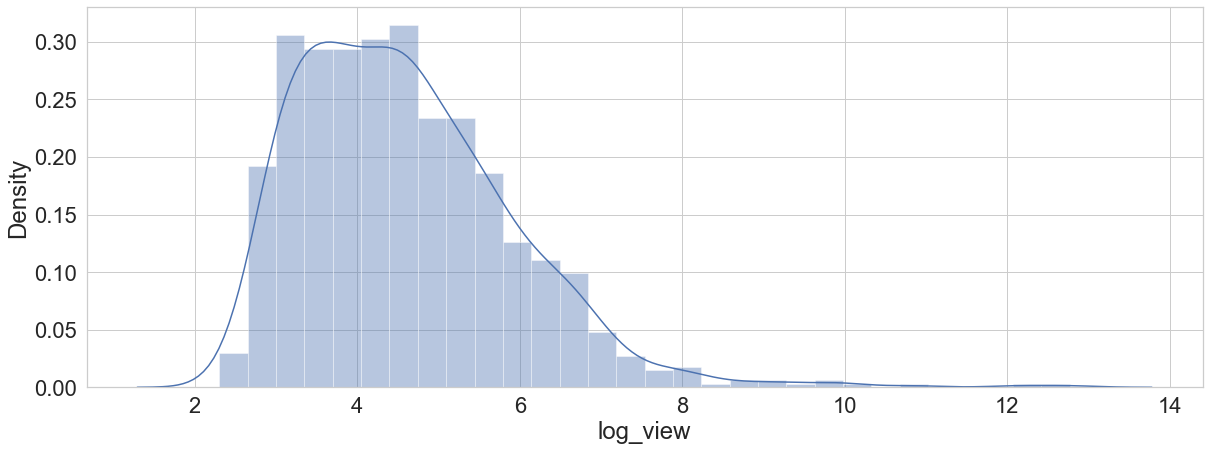

In [141]:
sns.distplot(click_and_view.log_view)

Теперь нужно найти среднее количество показов на 1 объявление (ad_id) по дням, не учитывая объявления, у которых не было показов (обычное среднее).

In [143]:
mean = ads_data.query("event == 'view'") \
    .groupby(['ad_id', 'date']) \
    .agg({'time' : 'count'}) \
    .groupby('date').mean().reset_index()

mean

,date,time
0,2019-04-01,154.482270
1,2019-04-02,137.786982
2,2019-04-03,163.952778
3,2019-04-04,675.901720
4,2019-04-05,919.109677
5,2019-04-06,277.122727


Посчитайте скользящее среднее по полученному результату с окном в 2 элемента.

In [144]:
rolling_mean_2 = ads_data.query("event == 'view'") \
    .groupby(['ad_id', 'date']) \
    .agg({'time' : 'count'}) \
    .groupby('date').mean().rolling(2).mean().reset_index()

rolling_mean_2

,date,time
0,2019-04-01,NaN
1,2019-04-02,146.134626
2,2019-04-03,150.869880
3,2019-04-04,419.927249
4,2019-04-05,797.505699
5,2019-04-06,598.116202


Нанести на один график значения просто среднего количества показов по дням и скользящего среднего на основе этих данных

<AxesSubplot:xlabel='date', ylabel='time'>

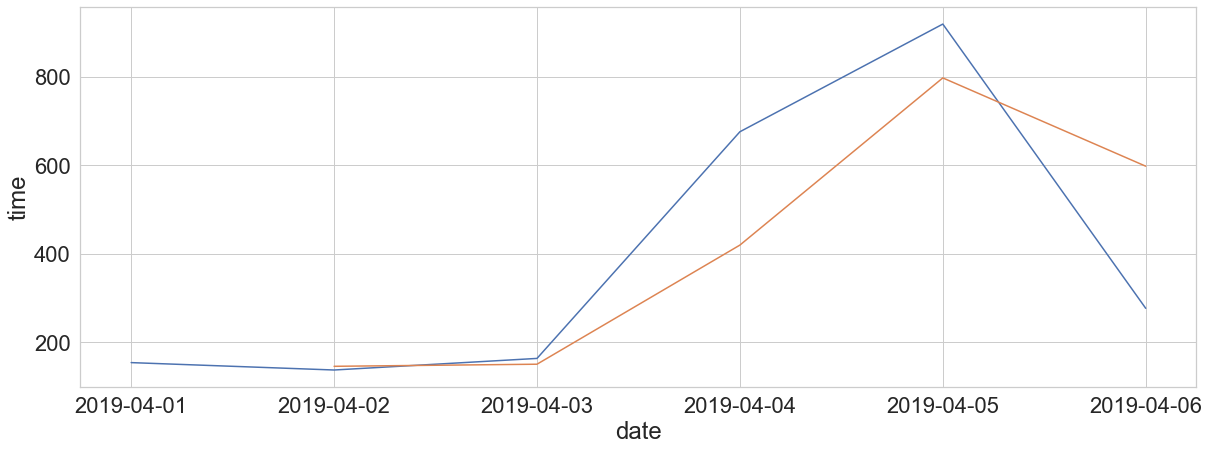

In [145]:
sns.lineplot(data=mean, x="date", y="time")
sns.lineplot(data=rolling_mean_2, x="date", y="time")

Посчитайте, в какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним?

In [146]:
mean.set_index('date').subtract(rolling_mean_2.set_index('date')).abs().idxmax()

time    2019-04-06
dtype: object

Объедините данные рекламы с данными о рекламных клиентах

In [147]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [148]:
ads_clients_data

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08
...,...,...,...,...
122073,2020-05-07,122074,-130470790,2018-12-21
122074,2020-05-07,122075,-130911261,2018-11-09
122075,2020-05-07,122076,-130494912,2018-10-27
122076,2020-05-07,122077,-130910585,2018-12-05


In [149]:
merged_data = ads_data.merge(ads_clients_data, on='client_union_id') \
    .rename(columns={'date_x' : 'date_ads_data', 'date_y' : 'ads_clients_data'})

In [150]:
merged_data[['date_ads_data', 'ads_clients_data', 'create_date']] = \
  merged_data[['date_ads_data', 'ads_clients_data', 'create_date']].apply(pd.to_datetime)


Найдём среднее количество дней от даты создания рекламного клиента (create_date) и первым запуском рекламного объявления этим клиентом (date).

In [152]:
merged_data["date_diff"] = merged_data.date_ads_data-merged_data.create_date

In [153]:
clients_with_ads = merged_data.groupby('client_union_id', as_index=False).agg({'date_diff' : 'min'})

In [154]:
# среднее количество дней от даты создания рекламного клиента
clients_with_ads.date_diff.mean().days

124

Разобъем наших клиентов по промежуткам от создания рекламного кабинета до запуска первого рекламного объявления:  
[0, 30, 90, 180, 365]

In [155]:
clients_with_ads['date_diff_categorical'] = pd.cut(clients_with_ads.date_diff,
                                 bins=pd.to_timedelta(['0d', '30d', '90d', '180d', '365d']),
                                 labels=['0-30 days', '30-90 days', '90-180 days', '180-365 days'])
clients_with_ads

,client_union_id,date_diff,date_diff_categorical
0,1,98 days,90-180 days
1,9,114 days,90-180 days
2,13,66 days,30-90 days
3,16,105 days,90-180 days
4,20,32 days,30-90 days
...,...,...,...
833,122004,67 days,30-90 days
834,122013,151 days,90-180 days
835,122023,126 days,90-180 days
836,122031,96 days,90-180 days


Определите, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней).

In [156]:
clients_with_ads[clients_with_ads['date_diff_categorical'] == '0-30 days'].count()

client_union_id          11
date_diff                11
date_diff_categorical    11
dtype: int64

Постройте интерактивный барплот, на котором будут показаны категории с количеством уникальных клиентов в них

In [157]:
fig = px.bar(clients_with_ads, x='date_diff_categorical')
fig.show()